# OSAVC Logfile Analysis 
This document performs some basic analysis of a logfile from the autonomous ground vehicle (AGV).
First import some dependencies:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from haversine import calc_earth_radius, haversine

Next, let's load a logfile to analyze:

In [3]:
filename = '.\logfiles\Log_02262022_bike_path.csv'
df_raw = pd.read_csv(filename)

With our version of mavlink, the timestamp for each variable can be either in milliseconds or microseconds.  To ease plotting and analysis, we merge them into a single time variable.

In [4]:
df_raw['time_msec'] = df_raw['time_usec']/1000
df_raw['time_merged'] = np.where(df_raw['time_msec']>df_raw['time_boot_ms'],df_raw['time_msec']/1000,df_raw['time_boot_ms']/1000)
df_raw['time_elapsed'] = df_raw['time_merged'] - df_raw['time_merged'][0]

## GPS Track in Local Coordinates
First, let's convert the GPS data into a local coordinate frame using an approximation based on our latitude in Santa Cruz (37 degrees N), then plot the local coordinates.

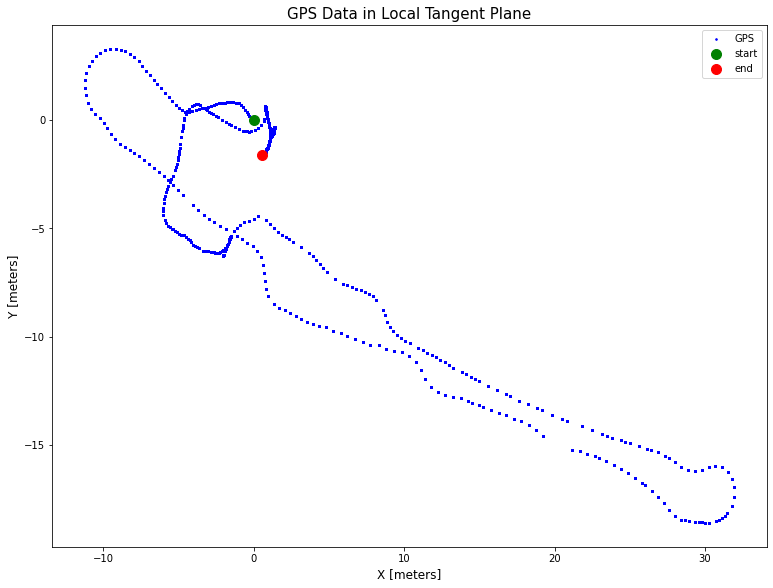

In [5]:
# calc earth radius at LTP
R = calc_earth_radius(df_raw.lat[0]/1e7)
# print(R)
# cal scaling factor for longitude conversion to meters
cos_lat = np.cos(df_raw.lat[0]*np.pi/(180*1e7))
# print(cos_lat)
# The data is in degrees * 1e7, so convert to radians in a new variable 
df_raw['X'] = (df_raw['lon']-df_raw['lon'][0])*(np.pi/(180*1e7))*(R *cos_lat *1000)
df_raw['Y'] = (df_raw['lat']-df_raw['lat'][0])*(np.pi/(180*1e7))*(R *1000)
# plot the data
fig,ax = plt.subplots(figsize=[12.8,9.6])
ax.scatter(df_raw['X'], df_raw['Y'],
           s=10, marker='.', color='blue',label='GPS')
ax.scatter(0,0, s=100, marker='o', color='green',label='start')
ax.scatter(df_raw['X'].tail(1),df_raw['Y'].tail(1), s=100, marker='o', color='red',label='end')
ax.set_xlabel('X [meters]',fontsize=12)
ax.set_ylabel('Y [meters]',fontsize=12)
ax.set_title('GPS Data in Local Tangent Plane',fontsize=15)
ax.legend()
plt.show()

## IMU data
Let's look at the mag, gyro, and accelerometer signals. 

In [15]:
import dorveaux_2d

Calibrate the magnetometer with course data

In [10]:
y_i = df_raw[['xmag','ymag']].values
[A,B] = dorveaux_2d.imu_calibrate(y_i,10)
y_cal = ((A@y_i.T) + B).T

Exec time: 4.384997367858887


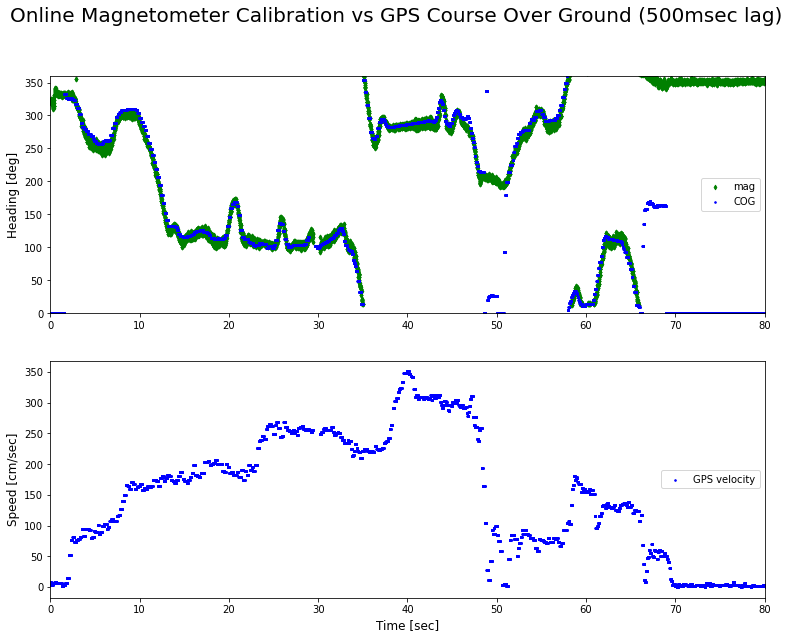

In [51]:
def calc_heading(data, offset =12.98):
    n= data.shape[0]
    heading = np.zeros((n,1))
  # heading in degrees:
    heading = np.degrees(np.arctan2(data[:,1],data[:,0])) + offset + 180
    return heading
heading = calc_heading(y_cal)
# plot the data vs COG

fig,ax = plt.subplots(2,figsize=[12.8,9.6])
fig.suptitle('Online Magnetometer Calibration vs GPS Course Over Ground (500msec lag)',fontsize=20)
xlim=[0,80]
ax[0].scatter(df_raw['time_elapsed'],heading,
           s=10, marker='d', color='green', label='mag')
ax[0].scatter(df_raw['time_elapsed']-.5,df_raw['cog']/100,
           s=10, marker='.', color='blue',label='COG')
ax[0].set_xlim(xlim)
ax[0].set_ylim([0,360])
ax[0].set_ylabel('Heading [deg]',fontsize=12)

ax[0].legend(loc='right')
ax[1].scatter(df_raw['time_elapsed'],df_raw['vel'],
           s=10, marker='.', color='blue', label='GPS velocity')
ax[1].set_xlim(xlim)
ax[1].set_xlabel('Time [sec]',fontsize=12)
ax[1].set_ylabel('Speed [cm/sec]',fontsize=12)
ax[1].legend(loc='right')
plt.show()

## GPS Speed and Wheel Speed
Compare the GPS-derived velocity and compare to the wheel encoders. The angular encoders report velocity in counts/sampling time, where the sampling time is set in the C firmware.  In this case at 100Hz. It is a 14 bit resolution encoder, so 2^14 - 1 is 2*pi

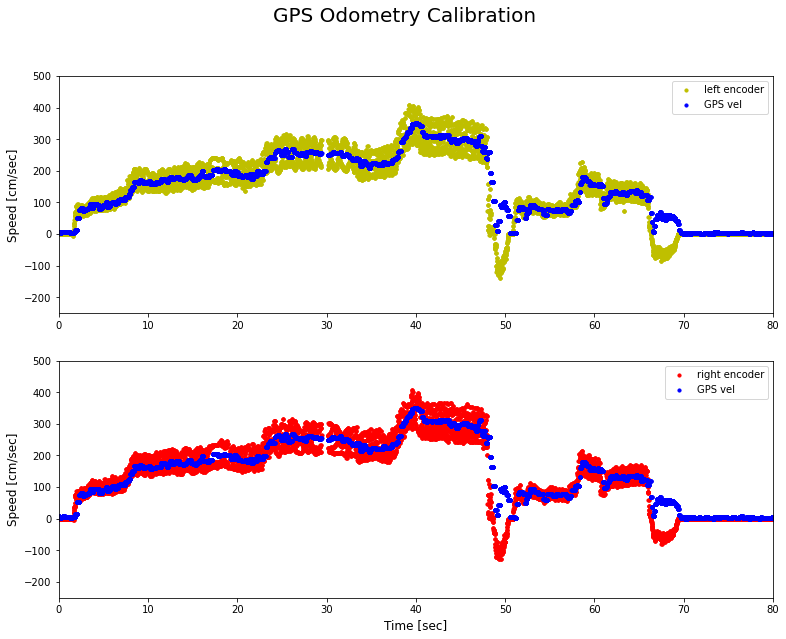

Estimated scale factor 0.1227184630308513
left wheel scale factor is 0.11989773669930033
right wheel scale factor is 0.12028478100132883


In [61]:
w_r = 3.2 # wheel circumference in cm
dT = 0.02 # 20 msec reporting period
freq = 100 # sampling frequency
scale = (np.pi*w_r)/(2**13) * freq # +/- pi rad/sec @ 14 bit resolution sampled at 100 Hz

scale_l = df_raw['vel'][1000:7500].mean()/df_raw['chan1_scaled'][1000:7500].mean()
scale_r = df_raw['vel'][1000:7500].mean()/df_raw['chan2_scaled'][1000:7500].mean()

fig,ax = plt.subplots(2,figsize=[12.8,9.6])
fig.suptitle('GPS Odometry Calibration',fontsize=20)
ylim=[-250,500]
xlim=[0,80]
ax[0].scatter(df_raw['time_elapsed'],df_raw['chan1_scaled']*scale_l,s=10,color='y', label='left encoder')
ax[0].scatter(df_raw['time_elapsed'],df_raw['vel'],s=10, color='b',label='GPS vel')
ax[0].set_xlim(xlim)
ax[0].set_ylim(ylim)
ax[0].set_ylabel('Speed [cm/sec]', fontsize = 12)
ax[0].legend(loc='upper right')
ax[1].scatter(df_raw['time_elapsed'],df_raw['chan2_scaled']*scale_r,s=10,color='r',label='right encoder')
ax[1].scatter(df_raw['time_elapsed'],df_raw['vel'],s=10, color='b',label='GPS vel')
ax[1].set_xlim(xlim)
ax[1].set_ylim(ylim)
ax[1].set_xlabel('Time [sec]',fontsize=12)
ax[1].set_ylabel('Speed [cm/sec]', fontsize = 12)
ax[1].legend(loc='upper right')
plt.show()
# calculate the measured radius 
print('Estimated scale factor', scale)
print('left wheel scale factor is', scale_l)
print('right wheel scale factor is', scale_r)

### Angular Velocity Calibration 
let's look at the yaw axis gyroscope data.  

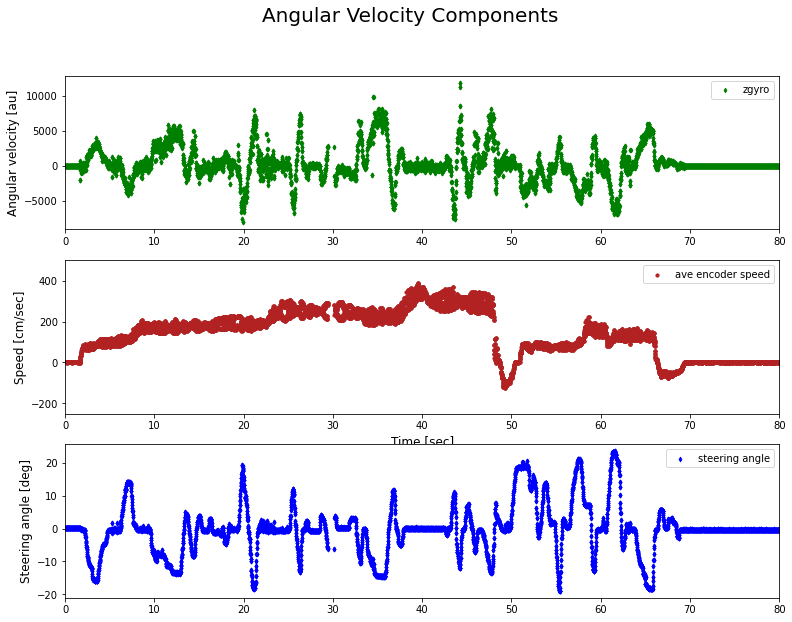

In [62]:
delta_zero = df_raw['chan4_scaled'][6118:6611].mean()
cts_deg = 360/2**14
# print(delta_zero)

fig,ax = plt.subplots(3,figsize=[12.8,9.6])
fig.suptitle('Angular Velocity Components',fontsize=20)
xlim = [0,80]
ax[0].scatter(df_raw['time_elapsed'],df_raw['zgyro'],
           s=10, marker='d', color='green', label='zgyro')
ax[0].set_xlim(xlim)
ax[0].set_ylabel('Angular velocity [au]',fontsize=12)
ax[0].legend(loc='upper right')

ax[1].scatter(df_raw['time_elapsed'],(df_raw['chan1_scaled']*scale_l + df_raw['chan2_scaled']*scale_r)/2,s=10,color='firebrick',label='ave encoder speed')
ax[1].set_xlim(xlim)
ax[1].set_ylim(ylim)
ax[1].set_xlabel('Time [sec]',fontsize=12)
ax[1].set_ylabel('Speed [cm/sec]', fontsize = 12)
ax[1].legend(loc='upper right')

ax[2].scatter(df_raw['time_elapsed'],(df_raw['chan4_scaled']-delta_zero)*cts_deg,
           s=10, marker='d', color='blue', label='steering angle')
ax[2].set_xlim(xlim)
ax[2].set_ylabel('Steering angle [deg]',fontsize=12)
ax[2].legend(loc='upper right')
plt.show()

### Calculate angular velocity from encoder data

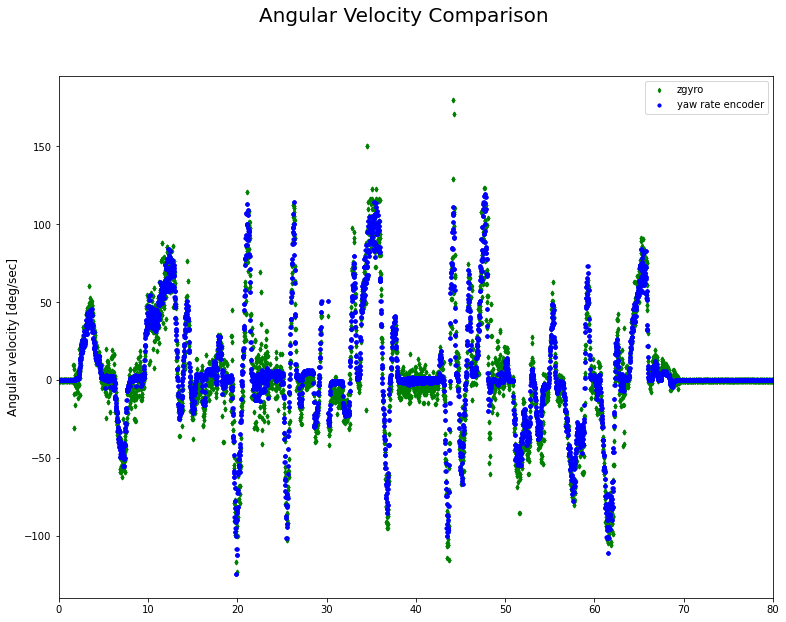

In [80]:
l = 17.3 # wheelbase, measured, in cm
cts_rad = 2*np.pi/(2**14) # 2pi FS 14 bits
gyro_scale = 500/(2**15) # +/-500 dps FS 16 bit
df_raw['zgyro_scaled'] =df_raw['zgyro']*gyro_scale
df_raw['enc_c_vel'] = (df_raw['chan1_scaled']*scale_l + df_raw['chan2_scaled']*scale_r)/2
df_raw['delta'] = -(df_raw['chan4_scaled']-delta_zero)*cts_rad
df_raw['yaw_rate_enc'] = df_raw['enc_c_vel']*np.tan(df_raw['delta'])*(180/(2*np.pi*l))

fig,ax = plt.subplots(figsize=[12.8,9.6])
fig.suptitle('Angular Velocity Comparison',fontsize=20)
xlim = [0,80]
ax.scatter(df_raw['time_elapsed'],df_raw['zgyro_scaled'],
           s=10, marker='d', color='green', label='zgyro')
ax.scatter(df_raw['time_elapsed'], df_raw['yaw_rate_enc'],s=10,color='blue',label='yaw rate encoder')
ax.set_xlim(xlim)
ax.set_ylabel('Angular velocity [deg/sec]',fontsize=12)
ax.legend(loc='upper right')
# w = v_c * tan(delta)/l


plt.show()

![Bicycle_model](./images/bicycle_model.png)

* $F_{\gamma r}$ is rear tire normal force
* $F_{\gamma f}$ is front tire normal force
* $\omega$ is angular velocity
* $\alpha_r$ is rear tire slip angle
* $\alpha_f$ is front tire slip angle
* $\delta$ is steering angle
* $U$ is forward velocity
* $V$ is lateral velocity
* $L_r$ is distance from center of mass to rear axle
* $L_f$ is distance from center of mass to front axle

